In [1]:
import pandas as pd
from math import sqrt
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
import sys
import os

# Get the absolute path to the 'src' directory
sys.path.append(os.path.abspath(".."))
print(os.path.abspath(".."))
project_root = os.path.abspath("..")
print(sys.path)
print(project_root)

/home/julia/school/bakalarka/hospital_sim
['/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages', '/home/julia/school/bakalarka/hospital_sim']
/home/julia/school/bakalarka/hospital_sim


In [3]:
from src.main import App
from src.data_generator import DataGenerator
from src.process_data import DataProcessor

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
exp_layout = project_root + "/input/experiments/layouts/expLayout.json"
two_nurses = project_root + "/input/experiments/people/expTwoNurses.json" #two nurses, 4 patients each, 2 patients per room
one_nurse = project_root + "/input/experiments/people/expOneNurse.json" #one nurse, 8 patients, 2 patients per room
exp_nurse_log = project_root + "/output/expNurseLog.csv"
exp_event_log = project_root + "/output/expEventLog.csv"
event_paths = ["expEvents1.json",
"expEvents2.json",
"expEvents3.json",
"expEvents4.json",
"expEvents5.json",
"expEvents6.json",
"expEvents7.json",
"expEvents8.json",]
full_event_paths = list(map(lambda x: project_root + "/input/experiments/events/" + x, event_paths))

In [5]:
# full_event_paths = list(map(lambda x: project_root + "/input/experiments/events/" + x, event_paths))
print(full_event_paths)


['/home/julia/school/bakalarka/hospital_sim/input/experiments/events/expEvents1.json', '/home/julia/school/bakalarka/hospital_sim/input/experiments/events/expEvents2.json', '/home/julia/school/bakalarka/hospital_sim/input/experiments/events/expEvents3.json', '/home/julia/school/bakalarka/hospital_sim/input/experiments/events/expEvents4.json', '/home/julia/school/bakalarka/hospital_sim/input/experiments/events/expEvents5.json', '/home/julia/school/bakalarka/hospital_sim/input/experiments/events/expEvents6.json', '/home/julia/school/bakalarka/hospital_sim/input/experiments/events/expEvents7.json', '/home/julia/school/bakalarka/hospital_sim/input/experiments/events/expEvents8.json']


In [6]:
params1 = {"event_path" : full_event_paths[0], "nurse_cnt": 2, "people_path": two_nurses, "request_assigner": "basic", "include_plans": True}
params2 = {"event_path" : full_event_paths[1], "nurse_cnt": 2, "people_path": two_nurses, "request_assigner": "other", "include_plans": True}
params3 = {"event_path" : full_event_paths[2], "nurse_cnt": 1, "people_path": one_nurse,  "request_assigner": "basic", "include_plans": True}
params4 = {"event_path" : full_event_paths[3], "nurse_cnt": 1, "people_path": one_nurse,  "request_assigner": "other", "include_plans": True}
params5 = {"event_path" : full_event_paths[4], "nurse_cnt": 2, "people_path": two_nurses, "request_assigner": "basic", "include_plans": False}
params6 = {"event_path" : full_event_paths[5], "nurse_cnt": 2, "people_path": two_nurses, "request_assigner": "other", "include_plans": False}
params7 = {"event_path" : full_event_paths[6], "nurse_cnt": 1, "people_path": one_nurse,  "request_assigner": "basic", "include_plans": False}
params8 = {"event_path" : full_event_paths[7], "nurse_cnt": 1, "people_path": one_nurse,  "request_assigner": "other", "include_plans": False}
params_lst = [params1, params2, params3, params4, params5, params6, params7, params8]

In [7]:
def generate_exp(params):
    # exp_events = project_root + "/input/events/" + exp_event_path
    # if nurse_cnt == 1:
    #     people_file = one_nurse
    # elif nurse_cnt == 2:
    #     people_file = two_nurses
    event_gen = DataGenerator(rnd=42, layout_file=exp_layout, people_file=params["people_path"], out_file=params["event_path"], request_assigner=params["request_assigner"],
                               include_plans=params["include_plans"])
    event_gen.create_events() 

In [8]:
def run_exp(params):
    app = App(exp_layout, params["people_path"], params["event_path"], exp_nurse_log, exp_event_log)
    app.run_simulation()

In [9]:
def process_nurse_data(params):
    dp = DataProcessor(exp_nurse_log, exp_event_log, params["people_path"])
    all_results = []
    for i in range(params["nurse_cnt"]):
        nurse_results = {}
        nurse_results["nurse_dst_walked"] = dp.nurse_dst_walked(i)
        nurse_results["nurse_time_walked"] = dp.nurse_time_walked(i)
        nurse_results["nurse_time_at_own_patients"] = dp.nurse_time_at_own_patients(i)
        nurse_results["nurse_time_at_other_patients"] = dp.nurse_time_at_other_patients(i)
        nurse_results["nurse_time_resting"] = dp.nurse_time_resting(i)
        all_results.append(nurse_results)
    return all_results

In [10]:
def process_patient_data(params):
    dp = DataProcessor(exp_nurse_log, exp_event_log, params["people_path"])
    all_results = []
    for i in range(8):
        patient_results = []
        for lvl in range(4):
            if lvl == 0:
                lvl = None

            level_results = {}
            level_results["total_time_waiting"] = dp.patient_total_time_waiting(i, lvl)
            level_results["avg_time_waiting"] = dp.patient_avg_time_waiting(i, lvl) #could be changed to histogram somehow
            patient_results.append(level_results)
        all_results.append(patient_results)
    return all_results


In [11]:
for params in params_lst:
    generate_exp(params)

------------------MAX DST 17.0 --------------------
{'time': 2867.554752696838, 'patient': 0, 'level': 3, 'duration': 139.79909127171078}
{'time': 2155.170543109332, 'patient': 0, 'level': 3, 'duration': 96.87491292803867}
{'time': 359.9096969448104, 'patient': 0, 'level': 3, 'duration': 159.92642186624028}
{'time': 2164.0140422755517, 'patient': 0, 'level': 3, 'duration': 33.08767414437037}
{'time': 3491.6754677831796, 'patient': 0, 'level': 2, 'duration': 61.85086660174142}
{'time': 654.5698819455622, 'patient': 0, 'level': 1, 'duration': 122.62222644415748}
{'time': 2201.9513777578113, 'patient': 0, 'level': 1, 'duration': 94.79175279631737}
{'time': 1048.4249047129508, 'patient': 0, 'level': 3, 'duration': 89.97914575728832}
{'time': 167.99638756901552, 'patient': 0, 'level': 3, 'duration': 98.41049763255539}
{'time': 2226.189633599114, 'patient': 1, 'level': 3, 'duration': 177.48463287101822}
{'time': 1680.3464156927278, 'patient': 1, 'level': 1, 'duration': 121.13172778521576}
{'

In [12]:
nurse_results = []
patient_results = []
done = []
for i, params in enumerate(params_lst):  
    run_exp(params)
    done.append(i)
    exp_results_nurse = process_nurse_data(params)
    nurse_results.append(exp_results_nurse)
    exp_results_patient = process_patient_data(params)
    patient_results.append(exp_results_patient)

importing
------------------MAX DST 17.0 --------------------
Simulating...
---------------------------UPDATED EXPORTER-----------------------------


/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


importing
------------------MAX DST 17.0 --------------------
Simulating...
---------------------------UPDATED EXPORTER-----------------------------
importing
------------------MAX DST 17.0 --------------------
Simulating...
---------------------------UPDATED EXPORTER-----------------------------


/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


importing
------------------MAX DST 17.0 --------------------
Simulating...
---------------------------UPDATED EXPORTER-----------------------------


/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


importing
------------------MAX DST 17.0 --------------------
Simulating...
---------------------------UPDATED EXPORTER-----------------------------


/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


importing
------------------MAX DST 17.0 --------------------
Simulating...
---------------------------UPDATED EXPORTER-----------------------------


/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


importing
------------------MAX DST 17.0 --------------------
Simulating...
---------------------------UPDATED EXPORTER-----------------------------


/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


importing
------------------MAX DST 17.0 --------------------
Simulating...
---------------------------UPDATED EXPORTER-----------------------------


/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [13]:
run_exp(params_lst[0])

importing
------------------MAX DST 17.0 --------------------
Simulating...
---------------------------UPDATED EXPORTER-----------------------------


In [14]:
res = process_patient_data(params_lst[0])
for i, patient in enumerate(res):
    print(i)
    for lvl in patient:
        print(lvl)

0
{'total_time_waiting': np.float64(3491.5104694574807), 'avg_time_waiting': np.float64(387.9456077174979)}
{'total_time_waiting': np.float64(2314.033907600383), 'avg_time_waiting': np.float64(1157.0169538001915)}
{'total_time_waiting': np.float64(99.4284509296881), 'avg_time_waiting': np.float64(99.4284509296881)}
{'total_time_waiting': np.float64(1078.0481109274097), 'avg_time_waiting': np.float64(179.67468515456827)}
1
{'total_time_waiting': np.float64(2621.1883284078986), 'avg_time_waiting': np.float64(291.2431476008776)}
{'total_time_waiting': np.float64(1403.2223351501448), 'avg_time_waiting': np.float64(701.6111675750724)}
{'total_time_waiting': np.float64(712.5940572335456), 'avg_time_waiting': np.float64(237.53135241118187)}
{'total_time_waiting': np.float64(505.37193602420825), 'avg_time_waiting': np.float64(126.34298400605206)}
2
{'total_time_waiting': np.float64(1473.4999916133502), 'avg_time_waiting': np.float64(368.37499790333754)}
{'total_time_waiting': np.float64(550.69

/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [15]:
for res in nurse_results:
    print(res)

[{'nurse_dst_walked': 218.0, 'nurse_time_walked': np.float64(218.0), 'nurse_time_at_own_patients': np.float64(3112.270450542833), 'nurse_time_at_other_patients': 0, 'nurse_time_resting': np.float64(1272.5470811346386)}, {'nurse_dst_walked': 320.0, 'nurse_time_walked': np.float64(320.0), 'nurse_time_at_own_patients': np.float64(3873.001813449683), 'nurse_time_at_other_patients': 0, 'nurse_time_resting': np.float64(409.81571822778824)}]
[{'nurse_dst_walked': 406.0, 'nurse_time_walked': np.float64(406.0), 'nurse_time_at_own_patients': np.float64(2188.794711960325), 'nurse_time_at_other_patients': np.float64(1284.8199548162802), 'nurse_time_resting': np.float64(304.25134222074394)}, {'nurse_dst_walked': 350.17583435838424, 'nurse_time_walked': np.float64(350.17583435838424), 'nurse_time_at_own_patients': np.float64(2588.1818586334025), 'nurse_time_at_other_patients': np.float64(923.4757385825071), 'nurse_time_resting': np.float64(322.03257742305505)}]
[{'nurse_dst_walked': 923.414599495518

In [16]:
for i, exp in enumerate(patient_results):
    print("\nexperiment ", i)
    for j, patient in enumerate(exp):
        print("patient", j)
        for k, lvl in enumerate(patient):
            print("level", k, lvl)


experiment  0
patient 0
level 0 {'total_time_waiting': np.float64(3491.5104694574807), 'avg_time_waiting': np.float64(387.9456077174979)}
level 1 {'total_time_waiting': np.float64(2314.033907600383), 'avg_time_waiting': np.float64(1157.0169538001915)}
level 2 {'total_time_waiting': np.float64(99.4284509296881), 'avg_time_waiting': np.float64(99.4284509296881)}
level 3 {'total_time_waiting': np.float64(1078.0481109274097), 'avg_time_waiting': np.float64(179.67468515456827)}
patient 1
level 0 {'total_time_waiting': np.float64(2621.1883284078986), 'avg_time_waiting': np.float64(291.2431476008776)}
level 1 {'total_time_waiting': np.float64(1403.2223351501448), 'avg_time_waiting': np.float64(701.6111675750724)}
level 2 {'total_time_waiting': np.float64(712.5940572335456), 'avg_time_waiting': np.float64(237.53135241118187)}
level 3 {'total_time_waiting': np.float64(505.37193602420825), 'avg_time_waiting': np.float64(126.34298400605206)}
patient 2
level 0 {'total_time_waiting': np.float64(14

[np.float64(3491.5104694574807), np.float64(2621.1883284078986), np.float64(1473.4999916133502), np.float64(2399.065013473368), np.float64(8406.638274685183), np.float64(6690.551417505502), np.float64(9575.10807240368), np.float64(3301.9958509181806), np.float64(2236.886038443803), np.float64(4982.666790752332), np.float64(1454.9241849801576), np.float64(1949.1258047375134), np.float64(4961.984110362154), np.float64(10712.221115604212), np.float64(7107.789398408916), np.float64(2065.4823353766137), np.float64(13431.81404184104), np.float64(20205.974125469424), np.float64(11082.16553403094), np.float64(16549.79308410425), np.float64(25102.72186313176), np.float64(21387.622864413872), np.float64(31485.84453323453), np.float64(10991.665631940483), np.float64(24732.789372896885), np.float64(22399.20239270719), np.float64(5584.691885017422), np.float64(10219.344915143574), np.float64(20424.993623411036), np.float64(31676.472906229574), np.float64(30440.887817568324), np.float64(17634.608208

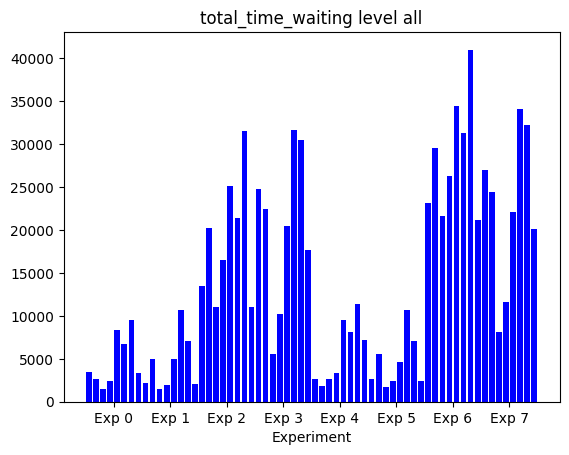

[np.float64(2314.033907600383), np.float64(1403.2223351501448), np.float64(550.6976085059678), np.float64(2216.2767173837474), np.float64(7741.313188201915), np.float64(2411.8330533455505), np.float64(7960.362476424163), np.float64(2316.792113065308), np.float64(1110.4249952945183), np.float64(1066.6939575818208), np.float64(249.28021293013853), np.float64(531.801203751158), np.float64(1707.8501264703834), np.float64(263.6498579239076), np.float64(1562.0357935350676), np.float64(168.60891764366488), np.float64(11610.040578974626), np.float64(11477.696389823013), np.float64(4993.213178733202), np.float64(16344.678808493783), np.float64(22125.07577811902), np.float64(5654.297393193143), np.float64(21978.51839460358), np.float64(5636.890526756222), np.float64(3438.5760863616088), np.float64(3111.51280868184), np.float64(1527.3438547687952), np.float64(5947.070836600566), np.float64(8266.598482261386), np.float64(1864.3829475067719), np.float64(7491.315254061747), np.float64(1975.740067538

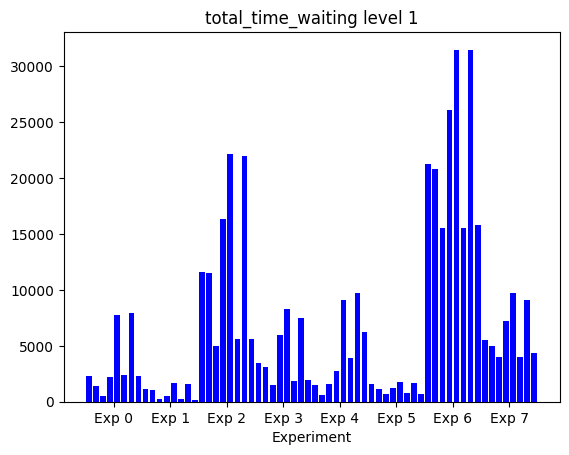

[np.float64(99.4284509296881), np.float64(712.5940572335456), np.float64(453.46968698380124), np.float64(182.7882960896211), np.float64(588.1533502923903), np.float64(1932.1120953405969), np.float64(432.1232985337558), np.float64(296.9956713186634), np.float64(461.3832995490816), np.float64(3390.5129799671117), np.float64(906.2376977926783), np.float64(1417.3246009863553), np.float64(3166.9622477008925), np.float64(4954.52988101387), np.float64(2204.042777288365), np.float64(1752.630475433641), np.float64(99.4284509296881), np.float64(4793.993421273728), np.float64(1277.840267295157), np.float64(205.11427561046662), np.float64(1838.0820368542632), np.float64(7703.627899126764), np.float64(5603.693206235636), np.float64(4322.914036439212), np.float64(3508.6584774387197), np.float64(13195.228619477024), np.float64(3757.9417559912854), np.float64(4272.274078543008), np.float64(12081.223404958771), np.float64(17435.272357200138), np.float64(9718.870376465553), np.float64(9048.88924068613),

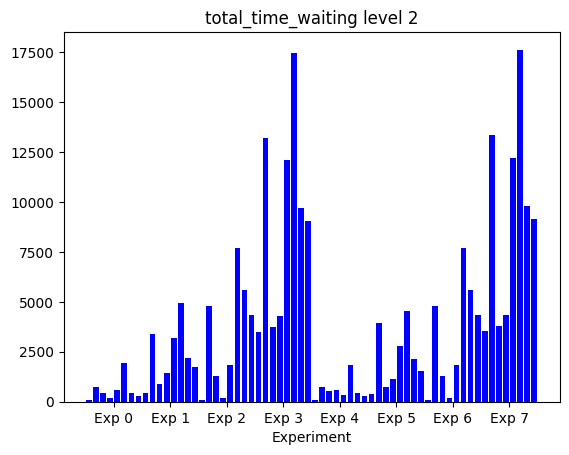

[np.float64(1078.0481109274097), np.float64(505.37193602420825), np.float64(469.3326961235811), 0, np.float64(77.17173619087816), np.float64(2346.606268819356), np.float64(1182.6222974457628), np.float64(688.2080665342091), np.float64(665.0777436002035), np.float64(525.4598532034004), np.float64(299.40627425734084), 0, np.float64(87.17173619087816), np.float64(5494.041376666436), np.float64(3341.710827585483), np.float64(144.24294229930774), np.float64(1722.3450119367258), np.float64(3934.2843143726836), np.float64(4811.112088002583), 0, np.float64(1139.5640481584774), np.float64(8029.697572093962), np.float64(3903.6329323953164), np.float64(1031.8610687450494), np.float64(17785.55480909656), np.float64(6092.460964548327), np.float64(299.40627425734084), 0, np.float64(77.17173619087816), np.float64(12376.817601522664), np.float64(13230.702187041024), np.float64(6609.97889995289), np.float64(1070.0481109274097), np.float64(505.37193602420825), np.float64(461.3326961235811), 0, np.float6

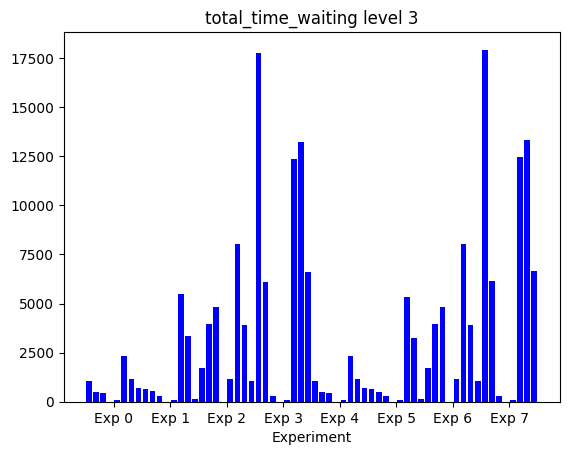

[np.float64(387.9456077174979), np.float64(291.2431476008776), np.float64(368.37499790333754), np.float64(599.766253368342), np.float64(934.0709194094648), np.float64(743.394601945056), np.float64(1063.9008969337422), np.float64(825.4989627295452), np.float64(248.54289316042255), np.float64(553.6296434169258), np.float64(363.7310462450394), np.float64(487.28145118437834), np.float64(551.3315678180172), np.float64(1190.2467906226902), np.float64(789.7543776009907), np.float64(516.3705838441534), np.float64(1492.423782426782), np.float64(2245.1082361632693), np.float64(2770.541383507735), np.float64(4137.448271026063), np.float64(2789.191318125751), np.float64(2376.4025404904296), np.float64(3498.4271703593927), np.float64(2747.9164079851207), np.float64(2748.087708099654), np.float64(2488.8002658563546), np.float64(1396.1729712543554), np.float64(2554.8362287858936), np.float64(2269.4437359345593), np.float64(3519.6081006921745), np.float64(3382.3208686187027), np.float64(4408.652052044

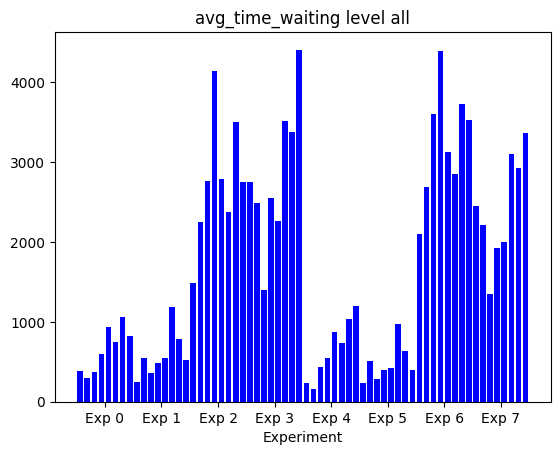

[np.float64(1157.0169538001915), np.float64(701.6111675750724), np.float64(550.6976085059678), np.float64(738.7589057945825), np.float64(1935.3282970504788), np.float64(2411.8330533455505), np.float64(1990.0906191060408), np.float64(2316.792113065308), np.float64(555.2124976472592), np.float64(533.3469787909104), np.float64(249.28021293013853), np.float64(177.26706791705269), np.float64(426.96253161759586), np.float64(263.6498579239076), np.float64(390.5089483837669), np.float64(168.60891764366488), np.float64(5805.020289487313), np.float64(5738.848194911507), np.float64(4993.213178733202), np.float64(5448.226269497928), np.float64(5531.268944529755), np.float64(5654.297393193143), np.float64(5494.629598650895), np.float64(5636.890526756222), np.float64(1719.2880431808044), np.float64(1555.75640434092), np.float64(1527.3438547687952), np.float64(1982.3569455335219), np.float64(2066.6496205653466), np.float64(1864.3829475067719), np.float64(1872.8288135154367), np.float64(1975.740067538

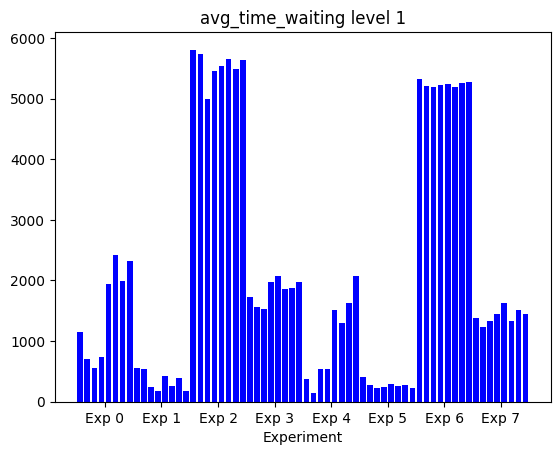

[np.float64(99.4284509296881), np.float64(237.53135241118187), np.float64(453.46968698380124), np.float64(182.7882960896211), np.float64(196.05111676413011), np.float64(483.0280238351492), np.float64(216.0616492668779), np.float64(148.4978356593317), np.float64(461.3832995490816), np.float64(1130.1709933223706), np.float64(906.2376977926783), np.float64(1417.3246009863553), np.float64(1055.6540825669642), np.float64(1238.6324702534675), np.float64(1102.0213886441825), np.float64(876.3152377168205), np.float64(99.4284509296881), np.float64(1597.9978070912427), np.float64(1277.840267295157), np.float64(205.11427561046662), np.float64(612.6940122847544), np.float64(1925.906974781691), np.float64(2801.846603117818), np.float64(2161.457018219606), np.float64(3508.6584774387197), np.float64(4398.409539825675), np.float64(3757.9417559912854), np.float64(4272.274078543008), np.float64(4027.0744683195903), np.float64(4358.818089300034), np.float64(4859.435188232776), np.float64(4524.44462034306

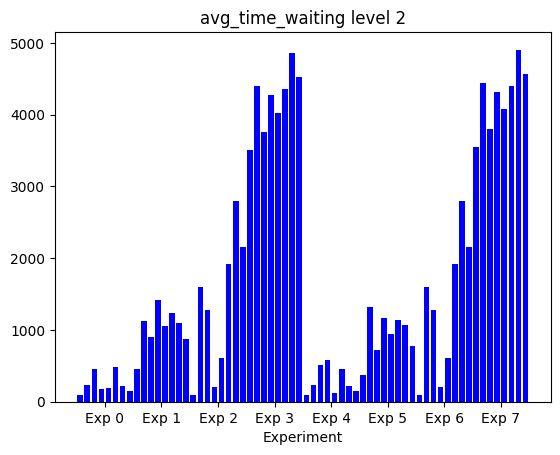

[np.float64(179.67468515456827), np.float64(126.34298400605206), np.float64(234.66634806179056), np.float64(nan), np.float64(38.58586809543908), np.float64(586.651567204839), np.float64(394.20743248192093), np.float64(688.2080665342091), np.float64(110.84629060003391), np.float64(131.3649633008501), np.float64(149.70313712867042), np.float64(nan), np.float64(43.58586809543908), np.float64(1373.510344166609), np.float64(1113.903609195161), np.float64(144.24294229930774), np.float64(287.0575019894543), np.float64(983.5710785931709), np.float64(2405.5560440012914), np.float64(nan), np.float64(569.7820240792387), np.float64(2007.4243930234904), np.float64(1301.2109774651055), np.float64(1031.8610687450494), np.float64(2964.2591348494266), np.float64(1523.1152411370817), np.float64(149.70313712867042), np.float64(nan), np.float64(38.58586809543908), np.float64(3094.204400380666), np.float64(4410.234062347008), np.float64(6609.97889995289), np.float64(178.34135182123495), np.float64(126.3429

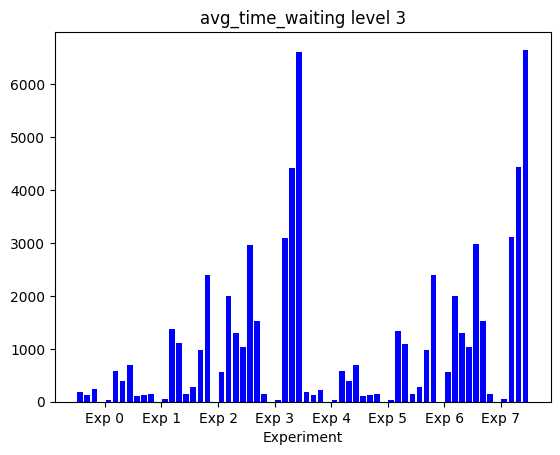

In [17]:
def plot_patient_stat(stat_name, level):
    if level == 0:
        level_title = "all"
    else:
        level_title = level
    values = []
    for i, exp in enumerate(patient_results):
        for j, patient in enumerate(exp):
            values.append(patient[level][stat_name])

    print(values)
    print(len(values))

    labels = ["Exp " + str(x) for x in range(8)]
    # colors = ['red' if i % 2 == 0 else 'blue' for i in range(len(values))]
    x = np.arange(len(values))
    plt.bar(x, values, color="blue")
    plt.xticks(ticks=np.arange(3.5, len(values), 8), labels=labels)

    plt.xlabel("Experiment")
    plt.ylabel("")
    plt.title(stat_name + " level " + str(level_title))

    # Show the chart
    plt.show()

for i in range(4):
    plot_patient_stat("total_time_waiting", i)

for i in range(4):
    plot_patient_stat("avg_time_waiting", i)

['Exp 1', 'Exp 2', 'Exp 3', 'Exp 4', 'Exp 5', 'Exp 6', 'Exp 7', 'Exp 8']
[218.0, 320.0, 406.0, 350.17583435838424, 923.4145994955186, 0, 700.0, 0, 214.0, 300.0, 348.0, 336.0, 953.4145994955186, 0, 820.170119290312, 0]


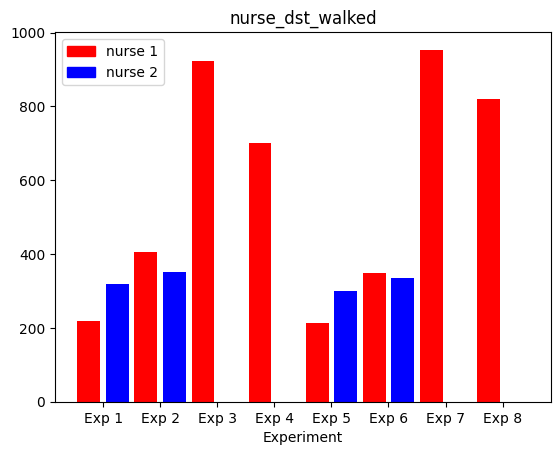

['Exp 1', 'Exp 2', 'Exp 3', 'Exp 4', 'Exp 5', 'Exp 6', 'Exp 7', 'Exp 8']
[np.float64(218.0), np.float64(320.0), np.float64(406.0), np.float64(350.17583435838424), np.float64(923.4145994955186), 0, np.float64(700.0000000000005), 0, np.float64(214.0), np.float64(300.0), np.float64(348.0), np.float64(336.0), np.float64(953.4145994955186), 0, np.float64(820.170119290312), 0]


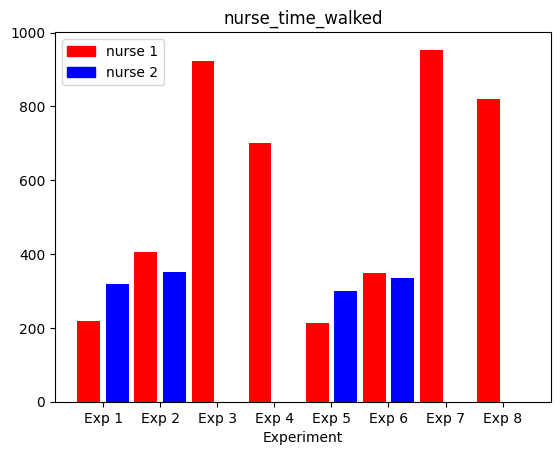

['Exp 1', 'Exp 2', 'Exp 3', 'Exp 4', 'Exp 5', 'Exp 6', 'Exp 7', 'Exp 8']
[np.float64(3112.270450542833), np.float64(3873.001813449683), np.float64(2188.794711960325), np.float64(2588.1818586334025), np.float64(6985.272263992513), 0, np.float64(6985.272263992512), 0, np.float64(3112.270450542833), np.float64(3873.0018134496813), np.float64(2221.340990916284), np.float64(2624.6765587170294), np.float64(6985.272263992513), 0, np.float64(6985.272263992514), 0]


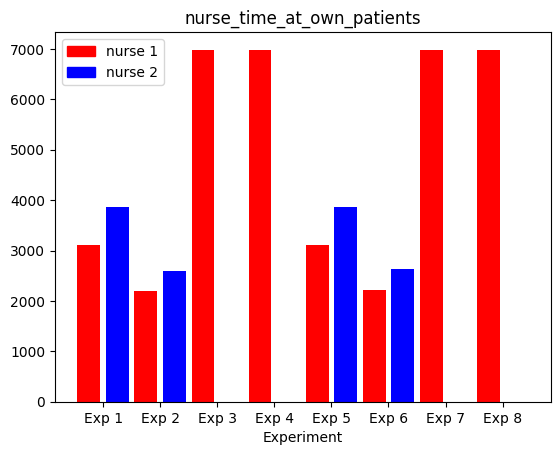

['Exp 1', 'Exp 2', 'Exp 3', 'Exp 4', 'Exp 5', 'Exp 6', 'Exp 7', 'Exp 8']
[0, 0, np.float64(1284.8199548162802), np.float64(923.4757385825071), 0, 0, 0, 0, 0, 0, np.float64(1248.3252547326542), np.float64(890.9294596265479), 0, 0, 0, 0]


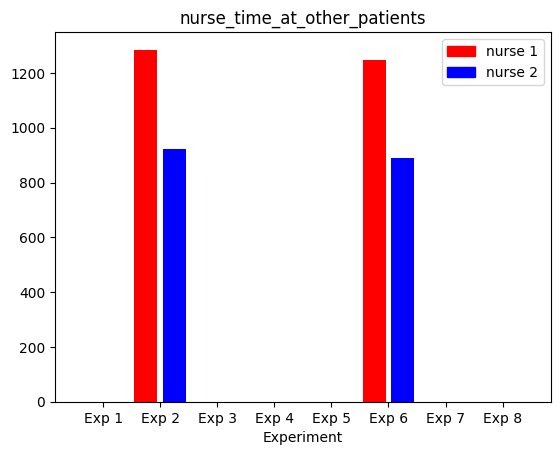

['Exp 1', 'Exp 2', 'Exp 3', 'Exp 4', 'Exp 5', 'Exp 6', 'Exp 7', 'Exp 8']
[np.float64(1272.5470811346386), np.float64(409.81571822778824), np.float64(304.25134222074394), np.float64(322.03257742305505), np.float64(556.7456029028274), 0, np.float64(425.29012227344856), 0, np.float64(1222.883156290155), np.float64(376.15179338330654), np.float64(293.92754947218964), np.float64(259.98777677755106), np.float64(526.7456029028274), 0, np.float64(351.20506262829167), 0]


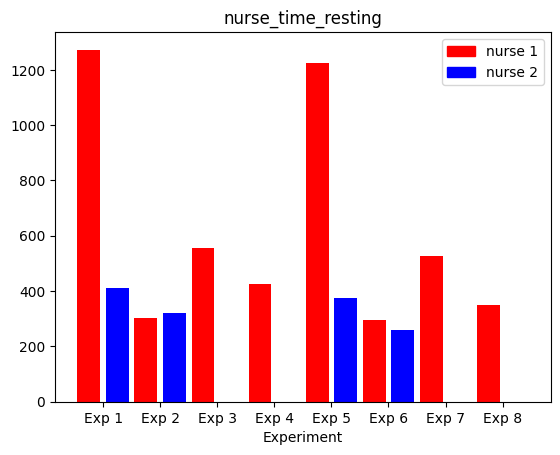

In [18]:
def plot_nurse_stat(stat_name):
    values = []
    for res in nurse_results:
        values.append(res[0][stat_name])
        if len(res) == 2:
            values.append(res[1][stat_name])
        else:
            values.append(0)

    labels = ["Exp " + str(x + 1) for x in range(8)]
    colors = ['red' if i % 2 == 0 else 'blue' for i in range(len(values))]
    print(labels)
    print(values)
    x = np.arange(len(values))

    plt.bar(x, values, color=colors)

    plt.xticks(ticks=np.arange(0.5, len(values), 2), labels=labels)

    # red_patch = plt.Line2D([0], [0], color='red', lw=4, label='nurse 1')
    # blue_patch = plt.Line2D([0], [0], color='blue', lw=4, label='nurse 2')
    red_patch = mpatches.Circle((0, 0), radius=0.1, color='red', label='nurse 1')
    blue_patch = mpatches.Circle((0, 0), radius=0.1, color='blue', label='nurse 2')
    plt.legend(handles=[red_patch, blue_patch])

    # Customize chart
    plt.xlabel("Experiment")
    plt.ylabel("")
    plt.title(stat_name)

    # Show the chart
    plt.show()

nurse_stats = nurse_results[0][0].keys()
for stat in nurse_stats:
    plot_nurse_stat(stat)

In [14]:
df = pd.read_csv(project_root + "/output/testNurseLog.csv")
df

,time,nurse,x,y,event,action,patient
0,0.000000,0,3.0,3.0,131,assign event,0.0
1,3.000000,0,6.0,3.0,131,move to,0.0
2,7.000000,0,6.0,7.0,131,move to,0.0
3,10.000000,0,3.0,7.0,131,move to,0.0
4,25.027670,0,3.0,7.0,131,unassign event,0.0
...,...,...,...,...,...,...,...
645,8401.562386,0,3.0,7.0,164,assign event,NaN
646,8404.562386,0,6.0,7.0,164,move to,NaN
647,8408.562386,0,6.0,3.0,164,move to,NaN
648,8411.562386,0,3.0,3.0,164,move to,NaN


In [17]:
time_rows = df[(df['nurse'] == 0) & (df['patient'] == 0) & (df['action'] == "time at patient")].event.tolist()
time_rows


[82, 131, 81, 79, 139, 75, 80, 78, 76, 77, 74]

In [18]:
df115 = df[df['event'] == 82].reset_index(drop=True)
df115

,time,nurse,x,y,event,action,patient
0,167.996388,0,3.0,7.0,82,assign event,0.0
1,266.406885,0,3.0,7.0,82,time at patient,0.0
2,266.406885,0,3.0,7.0,82,finish event,0.0


In [19]:
# Find the index of the row where action is 'time at patient'
time_at_patient_idx = df115[df115['action'] == 'time at patient'].index[0]
print(time_at_patient_idx)

total_time = 0
int_end_time = df115.loc[time_at_patient_idx].time #end of current calculated interval
# Iterate backward from this index to find the first occurrence of 'move to'
for idx in range(time_at_patient_idx, -1, -1):
    line = df115.loc[idx]
    action = line["action"]
    if action == 'move to' or idx == 0:
        total_time += int_end_time - line["time"]
        break
    if action == 'assign event':
        total_time += int_end_time - line["time"]
    elif action == 'unassign event':
        int_end_time = line["time"]
    print(idx, action, total_time)

print(total_time)

1
1 time at patient 0
98.41049763255538


In [29]:
df115.iloc[-1]

time        2928.664217
nurse                 0
x                  14.0
y                   3.0
event               115
action     finish event
patient             5.0
Name: 210, dtype: object